# Benchmark simulation
In this tutorial we will solve a single phase flow problem defined in Section 4.1 of [Flemisch et al. 2017](https://doi.org/10.1016/j.advwatres.2017.10.036). The simulation is based on the `SinglePhaseFlow` class, which is introduced in [this tutorial](./single_phase_flow.ipynb). We modify the model through domain, boundary conditions and constitutive laws. 
We also specify fluid and solid parameters. 


We start off by importing the necessary packages, and make a shorthand for the single phase flow model class:

In [17]:
import porepy as pp
import numpy as np
from porepy.models.fluid_mass_balance import SinglePhaseFlow

### Geometry
The default geometry is a unitary domain without any fractures. The benchmark problem is defined on the unit square, but contains a set of fractures which we access in PorePy's library of fracture sets. Specifications on how to mesh the domain will be passed as parameters below.

We also define the boundary conditions to be of Dirichlet type on the west and east boundary with pressure values of 1 and 0, respectively.

In [18]:
class BenchmarkGeometry:
    def set_fractures(self) -> None:
        """Setting a diagonal fracture"""
        self._fractures = pp.applications.md_grids.fracture_sets.benchmark_regular_2d_fractures()


class BenchmarkBCs:
    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign dirichlet to the west and east boundaries. The rest are Neumann by default."""
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.west + bounds.east, "dir")
        return bc

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Zero bc value on top, bottom and east, 1 on west side."""
        bounds = self.domain_boundary_sides(boundary_grid)
        values = np.zeros(boundary_grid.num_cells)
        # See section on scaling for explanation of the conversion.
        values[bounds.west] = self.fluid.convert_units(1, "Pa")
        return values

To complete the modifications to the `SinglePhaseFlow` model, we need to implement different permeability values depending on subdomain dimension. Something similar is implemented in the `CubicLawPermeability` class, but our needs are not quite met. Here, we add separate methods for each dimension and apply values from the passed parameters for fractures and intersections.  

In [19]:
class DimensionDependentPermeability(pp.constitutive_laws.ConstantPermeability):
    """Permeability depending on subdomain dimension."""

    def permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability [m^2].

        This function combines the permeability of the matrix, fractures and
        intersections.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability values.

        """
        projection = pp.ad.SubdomainProjections(subdomains, dim=1)
        matrix = [sd for sd in subdomains if sd.dim == self.nd]
        fractures: list[pp.Grid] = [
            sd for sd in subdomains if sd.dim == self.nd - 1
        ]
        intersections: list[pp.Grid] = [
            sd for sd in subdomains if sd.dim < self.nd - 1
        ]

        permeability = projection.cell_prolongation(matrix) @ self.matrix_permeability(
            matrix
        ) + projection.cell_prolongation(
            fractures
        ) @ self.fracture_permeability(
            fractures
        ) + projection.cell_prolongation(
            intersections
        ) @ self.intersection_permeability(
            intersections
        )
        return permeability


    def matrix_permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability of the matrix.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability operator.

        """
        return super().permeability(subdomains)  # One by default.

    def fracture_permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability of fractures.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability operator.

        """
        size = sum([sd.num_cells for sd in subdomains])
        val = self.params.get("fracture_permeability", 1e-4)
        return pp.wrap_as_dense_ad_array(self.solid.convert_units(val, "m^2"), size)

    def intersection_permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability of intersections.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability operator.

        """
        size = sum([sd.num_cells for sd in subdomains])
        val = self.params.get("intersection_permeability", 1e-4)
        return pp.wrap_as_dense_ad_array(self.solid.convert_units(val, "m^2"), size)


We can now combine the extensions with the base class:

In [20]:
class BenchmarkModel(
    BenchmarkGeometry,
    BenchmarkBCs,
    DimensionDependentPermeability,
    SinglePhaseFlow,
):
    """Combines all SinglePhaseFlow with adjustments as defined in the benchmark problem."""

We run the with both of the fracture permeability values defined in the benchmark. We also change the grid type for good measure.

c:\users\ist050\onedrive - university of bergen\documents\github\porepy\src\porepy\grids\mortar_grid.py:786: UserWarning: Is it really meaningful to ask for signs of a one sided mortar grid?
  warnings.warn(


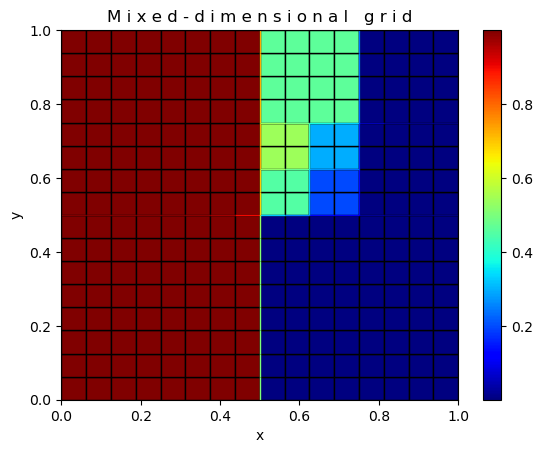

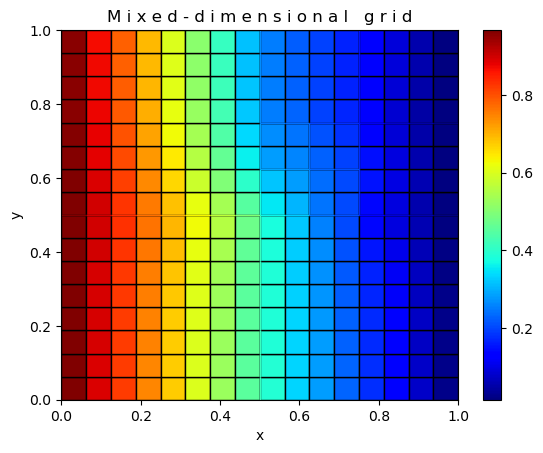

In [25]:
for k_f, grid_type in zip([1e-4, 1e4], ["cartesian", "simplex"]):
    # We use default fluid parameters but tailored solid parameters.
    solid_constants = pp.SolidConstants({"aperture": 1e-4, "normal_permeability": k_f})
    params = {
        "fracture_permeability": k_f,
        "intersection_permeability": k_f,
        "material_constants": {"solid": solid_constants},
        "grid_type": grid_type,
        "meshing_arguments": {"cell_size": 1/16}
    }
    model = BenchmarkModel(params)
    pp.run_time_dependent_model(model, params)
    pp.plot_grid(model.mdg, model.pressure_variable, figsize=(10, 8), plot_2d=True)

### Boundary conditions, fluid and solid constants
One example of how to include some driving forces is by defining some non-zero boundary conditions. 
This is done similarly to how we modified the geometry, meaning that we will now define a mixin for the boundary conditions. 
Methods for the boundary conditions are already present in the default model class, so modifying them can be done by overwriting the methods ``bc_type_darcy_flux_flux`` and ``bc_type_darcy_flux_flux``.

In [22]:
import numpy as np
import porepy as pp
from porepy.models.fluid_mass_balance import BoundaryConditionsSinglePhaseFlow

class ModifiedBC(BoundaryConditionsSinglePhaseFlow):
    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign dirichlet to the west and east boundaries. The rest are Neumann by default."""
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.west + bounds.east, "dir")
        return bc

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Zero bc value on top and bottom, 5 on west side, 2 on east side."""
        bounds = self.domain_boundary_sides(boundary_grid)
        values = np.zeros(boundary_grid.num_cells)
        # See section on scaling for explanation of the conversion.
        values[bounds.west] = self.fluid.convert_units(5, "Pa")
        values[bounds.east] = self.fluid.convert_units(2, "Pa")
        return values

To combine the standard model with the new geometry _and_ the boundary conditions, we simply create a new class which inherits from all of them:

In [23]:
class SinglePhaseFlowGeometryBC(
    ModifiedGeometry,
    ModifiedBC,
    SinglePhaseFlow):
    """Adding both geometry and modified boundary conditions to the default model."""
    ...

NameError: name 'ModifiedGeometry' is not defined

Before we go ahead and run the model, we will also have a look at how to change parameters present in the model.
Material constants are stored in and accessed through `SolidConstants` and `FluidConstants` objects.
Instantiating these classes is how we can make adjustments of the material constants. 

This is done by creating ``fluid`` and ``solid`` dictionaries inside the ``material_constants`` dictionary, which is again located within the ``params`` dictionary.
An example is shown below.

In [ ]:
fluid_constants = pp.FluidConstants({"viscosity": 0.1, "density": 0.2})
solid_constants = pp.SolidConstants({"permeability": 0.5, "porosity": 0.25})
material_constants = {"fluid": fluid_constants, "solid": solid_constants}
params = {"material_constants": material_constants}


Once the fluid and solid constants are defined within the ``params`` dictionary, we feed them to the model, and then run the simulation.

In [ ]:
model = SinglePhaseFlowGeometryBC(params)
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.25, title="Pressure distribution")

### Fracture source
Another way to modify the model is to include a fracture source.
Below we demonstrate how a unitary fracture source can be included by a rather simple modification to the method governing the fluid source

In [ ]:
class ModifiedSource:
    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Assign unitary fracture source"""
        # Retrieve internal sources (jump in mortar fluxes) from the base class
        internal_sources: pp.ad.Operator = super().fluid_source(subdomains)

        # Retrieve external (integrated) sources from the exact solution.
        values = []

        for sd in subdomains:
            if sd.dim == self.mdg.dim_max():
                values.append(np.zeros(sd.num_cells))
            else:
                values.append(np.ones(sd.num_cells))

        external_sources = pp.wrap_as_dense_ad_array(np.hstack(values))

        # Add up both contributions
        source = internal_sources + external_sources
        source.set_name("fluid sources")

        return source

For the sake of seeing the effects of the unitary fracture source, we do not include the non-zero boundary conditions.
This is simply done by not inheriting from ``ModifiedBC`` when creating the new model with a fracture source.

In [ ]:
class SinglePhaseFlowFractureSource(
    ModifiedGeometry,
    ModifiedSource,
    SinglePhaseFlow):
    """Including the fracture source mixin to the default model."""
    ...

model = SinglePhaseFlowFractureSource(params)
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.2, title="Pressure distribution")

## Compressible flow
Building upon the model with a unitary fracture source and zero boundary conditions, we will now consider a compressible fluid.


In [ ]:
class CompressibleFlow(
    ModifiedGeometry,
    ModifiedBC,
    ModifiedSource,
    SinglePhaseFlow
):
    """Combining modified geometry, boundary conditions and the source term with the default model.

    """
    ...


Setting the compressibility to a non-zero value makes the fluid compressible, and this makes the model time-dependent. 
For seeing the gradual evolution of the solution we also need to assign non-default values to the ``pp.TimeManager``. 

In other words, all previous simulations are only run with one time step as this is the default time step amount.
Simulations with multiple time steps require users to explicitly define parameters such as time step size and the time schedule.
The time manager, with the new, non-default time parameters, is passed to the model through the ``params`` dictionary.

In [ ]:
fluid_constants = pp.FluidConstants({"compressibility": 0.01})
material_constants = {"fluid": fluid_constants}

time_manager = pp.TimeManager(
    schedule=[0, 1e-3],
    dt_init=1e-4,
    constant_dt=True,
    iter_max=10,
    print_info=True,
)

params = {"material_constants": material_constants, "time_manager": time_manager}
model = CompressibleFlow(params)

Running the model and doing a simple visualization of the result is done in the exact same way as before:

In [ ]:
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.2)

The figure above shows the final solution, while the gradual evolvement of it can be visualized using e.g. ParaView. 
By default, all the primary variables of the model are saved at each time step. Unless specified otherwise, all exported files are stored in a folder named `visualization` in the working directory. 
For more details on how to customize the exporting, see the [exporting in models tutorial](./exporting_models.ipynb).


# What we have explored
We have had a look at how single physics simulations can be run with PorePy by modifying various different parts of the default models.

Specifically, we modified the following:
* Model geometry
* Boundary conditions
* Source term
* Material constants
* Time manager